In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 14):
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 8000, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 8000, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_52 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_52 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_53 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_53 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 8000, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_76 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 8000, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5685 - acc: 0.3053
Epoch 00001: val_loss improved from inf to 1.99143, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_3_conv_checkpoint/001-1.9914.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.5685 - acc: 0.3053 - val_loss: 1.9914 - val_acc: 0.3811
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6426 - acc: 0.5107
Epoch 00002: val_loss improved from 1.99143 to 1.85257, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_3_conv_checkpoint/002-1.8526.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.6426 - acc: 0.5107 - val_loss: 1.8526 - val_acc: 0.4556
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2643 - acc: 0.6139
Epoch 00003: val_loss improved from 1.85257 to 1.73

36800/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9696
Epoch 00028: val_loss did not improve from 1.67348
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1024 - acc: 0.9696 - val_loss: 3.0485 - val_acc: 0.5171
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1064 - acc: 0.9681
Epoch 00029: val_loss did not improve from 1.67348
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1063 - acc: 0.9681 - val_loss: 2.7981 - val_acc: 0.5392
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1066 - acc: 0.9678
Epoch 00030: val_loss did not improve from 1.67348
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1066 - acc: 0.9678 - val_loss: 2.5381 - val_acc: 0.5462
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1041 - acc: 0.9689
Epoch 00031: val_loss did not improve from 1.67348
36805/36805 [========================

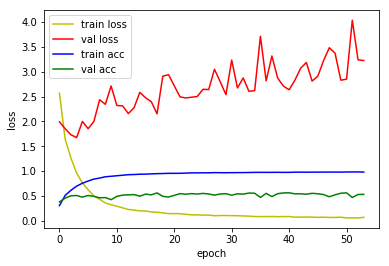

4815/4815 [==============================] - 3s 546us/sample - loss: 1.7968 - acc: 0.4739
Loss: 1.796771149942313 Accuracy: 0.4739356

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2761 - acc: 0.3258
Epoch 00001: val_loss improved from inf to 1.74845, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_4_conv_checkpoint/001-1.7484.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.2761 - acc: 0.3259 - val_loss: 1.7484 - val_acc: 0.4274
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5482 - acc: 0.5187
Epoch 00002: val_loss improved from 1.74845 to 1.34322, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_4_conv_checkpoint/002-1.3432.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.5481 - acc: 0.5187 - val_loss: 1.3432 - val_acc: 0.5819
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9542
Epoch 00029: val_loss did not improve from 1.28756
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1446 - acc: 0.9542 - val_loss: 1.6980 - val_acc: 0.6452
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1457 - acc: 0.9527
Epoch 00030: val_loss did not improve from 1.28756
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1457 - acc: 0.9527 - val_loss: 1.6228 - val_acc: 0.6625
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9563
Epoch 00031: val_loss did not improve from 1.28756
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1389 - acc: 0.9563 - val_loss: 1.6884 - val_acc: 0.6594
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1302 - acc: 0.9589
Epoch 00032: val_loss did not improve from 1.28756
36805/36805 [===========

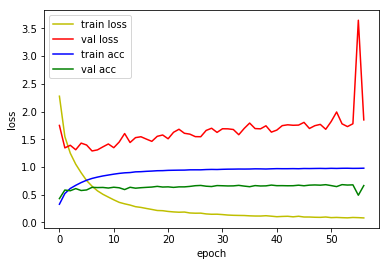

4815/4815 [==============================] - 3s 637us/sample - loss: 1.3985 - acc: 0.5985
Loss: 1.3984589152123204 Accuracy: 0.5985462

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1453 - acc: 0.3645
Epoch 00001: val_loss improved from inf to 1.53033, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_5_conv_checkpoint/001-1.5303.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 2.1451 - acc: 0.3645 - val_loss: 1.5303 - val_acc: 0.5297
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3749 - acc: 0.5683
Epoch 00002: val_loss improved from 1.53033 to 1.47438, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_5_conv_checkpoint/002-1.4744.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.3748 - acc: 0.5683 - val_loss: 1.4744 - val_acc: 0.5558
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.9587
Epoch 00028: val_loss did not improve from 1.16180
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1267 - acc: 0.9586 - val_loss: 1.4590 - val_acc: 0.7032
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9607
Epoch 00029: val_loss did not improve from 1.16180
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1189 - acc: 0.9607 - val_loss: 1.3803 - val_acc: 0.7184
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9633
Epoch 00030: val_loss did not improve from 1.16180
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1163 - acc: 0.9633 - val_loss: 1.7053 - val_acc: 0.6569
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1137 - acc: 0.9635
Epoch 00031: val_loss did not improve from 1.16180
36805/36805 [========================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9803
Epoch 00058: val_loss did not improve from 1.16180
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0649 - acc: 0.9803 - val_loss: 1.5649 - val_acc: 0.7149
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9810
Epoch 00059: val_loss did not improve from 1.16180
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0626 - acc: 0.9810 - val_loss: 1.6654 - val_acc: 0.7095
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9791
Epoch 00060: val_loss did not improve from 1.16180
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0672 - acc: 0.9791 - val_loss: 1.5352 - val_acc: 0.7216

1D_CNN_custom_pool_2_ch_32_DO_BN_5_conv Model


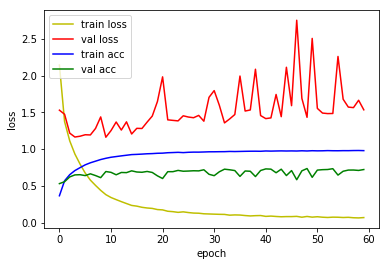

4815/4815 [==============================] - 3s 650us/sample - loss: 1.3318 - acc: 0.6422
Loss: 1.3317909630659586 Accuracy: 0.64215994

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1095 - acc: 0.3631
Epoch 00001: val_loss improved from inf to 1.70086, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_6_conv_checkpoint/001-1.7009.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 2.1094 - acc: 0.3631 - val_loss: 1.7009 - val_acc: 0.4573
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3837 - acc: 0.5738
Epoch 00002: val_loss improved from 1.70086 to 1.16782, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_6_conv_checkpoint/002-1.1678.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.3839 - acc: 0.5738 - val_loss: 1.1678 - val_acc: 0.6292
Epoch 3/500
36800/36805 [============================>.] -

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2028 - acc: 0.9356
Epoch 00028: val_loss did not improve from 0.82055
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2028 - acc: 0.9356 - val_loss: 0.8967 - val_acc: 0.7871
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1798 - acc: 0.9421
Epoch 00029: val_loss did not improve from 0.82055
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1798 - acc: 0.9421 - val_loss: 0.8665 - val_acc: 0.7927
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1765 - acc: 0.9430
Epoch 00030: val_loss did not improve from 0.82055
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1765 - acc: 0.9430 - val_loss: 0.8826 - val_acc: 0.7852
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9431
Epoch 00031: val_loss did not improve from 0.82055
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9723
Epoch 00058: val_loss did not improve from 0.82055
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0904 - acc: 0.9723 - val_loss: 1.0321 - val_acc: 0.7880
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9708
Epoch 00059: val_loss did not improve from 0.82055
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0922 - acc: 0.9708 - val_loss: 1.0326 - val_acc: 0.7820

1D_CNN_custom_pool_2_ch_32_DO_BN_6_conv Model


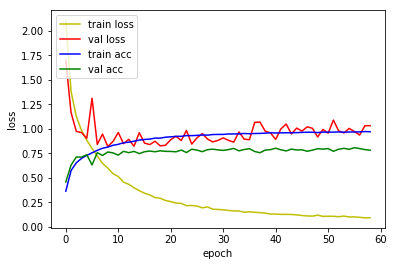

4815/4815 [==============================] - 3s 692us/sample - loss: 0.8959 - acc: 0.7481
Loss: 0.8959385441471112 Accuracy: 0.74807894

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1358 - acc: 0.3452
Epoch 00001: val_loss improved from inf to 1.49942, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_7_conv_checkpoint/001-1.4994.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.1356 - acc: 0.3452 - val_loss: 1.4994 - val_acc: 0.5076
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3457 - acc: 0.5744
Epoch 00002: val_loss improved from 1.49942 to 1.05996, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_7_conv_checkpoint/002-1.0600.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.3459 - acc: 0.5744 - val_loss: 1.0600 - val_acc: 0.6744
Epoch 3/500
36800/36805 [============================>.] -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2620 - acc: 0.9190
Epoch 00027: val_loss did not improve from 0.57785
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.2621 - acc: 0.9190 - val_loss: 0.6102 - val_acc: 0.8355
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2572 - acc: 0.9197
Epoch 00028: val_loss did not improve from 0.57785
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.2571 - acc: 0.9197 - val_loss: 0.8480 - val_acc: 0.7880
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2458 - acc: 0.9241
Epoch 00029: val_loss did not improve from 0.57785
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.2459 - acc: 0.9241 - val_loss: 0.6291 - val_acc: 0.8334
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2431 - acc: 0.9236
Epoch 00030: val_loss did not improve from 0.57785
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9629
Epoch 00057: val_loss did not improve from 0.57785
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1181 - acc: 0.9629 - val_loss: 0.7774 - val_acc: 0.8164
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9607
Epoch 00058: val_loss did not improve from 0.57785
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1251 - acc: 0.9607 - val_loss: 0.7533 - val_acc: 0.8374
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9634
Epoch 00059: val_loss did not improve from 0.57785
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.1180 - acc: 0.9634 - val_loss: 0.8261 - val_acc: 0.8160
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1249 - acc: 0.9617
Epoch 00060: val_loss did not improve from 0.57785
36805/36805 [===========

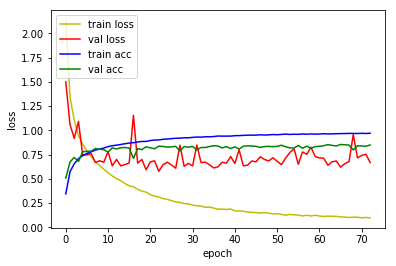

4815/4815 [==============================] - 4s 795us/sample - loss: 0.6977 - acc: 0.8123
Loss: 0.6976641787918186 Accuracy: 0.81225336

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3045 - acc: 0.3024
Epoch 00001: val_loss improved from inf to 1.54671, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_8_conv_checkpoint/001-1.5467.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 2.3044 - acc: 0.3024 - val_loss: 1.5467 - val_acc: 0.5141
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4055 - acc: 0.5520
Epoch 00002: val_loss improved from 1.54671 to 1.48371, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_8_conv_checkpoint/002-1.4837.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 1.4054 - acc: 0.5520 - val_loss: 1.4837 - val_acc: 0.5416
Epoch 3/500
36800/36805 [============================>.] -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2855 - acc: 0.9134
Epoch 00026: val_loss did not improve from 0.43253
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.2855 - acc: 0.9134 - val_loss: 0.4868 - val_acc: 0.8588
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2734 - acc: 0.9159
Epoch 00027: val_loss improved from 0.43253 to 0.41827, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_8_conv_checkpoint/027-0.4183.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.2734 - acc: 0.9159 - val_loss: 0.4183 - val_acc: 0.8884
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2708 - acc: 0.9182
Epoch 00028: val_loss did not improve from 0.41827
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.2709 - acc: 0.9181 - val_loss: 0.7480 - val_acc: 0.7934
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.1300 - acc: 0.9582
Epoch 00054: val_loss did not improve from 0.40134
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1300 - acc: 0.9581 - val_loss: 0.4385 - val_acc: 0.8928
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9578
Epoch 00055: val_loss did not improve from 0.40134
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1308 - acc: 0.9578 - val_loss: 0.5382 - val_acc: 0.8756
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1261 - acc: 0.9600
Epoch 00056: val_loss did not improve from 0.40134
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.1261 - acc: 0.9600 - val_loss: 0.4356 - val_acc: 0.8945
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9615
Epoch 00057: val_loss did not improve from 0.40134
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9725
Epoch 00084: val_loss did not improve from 0.40134
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0879 - acc: 0.9725 - val_loss: 0.4077 - val_acc: 0.9059
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0789 - acc: 0.9752
Epoch 00085: val_loss did not improve from 0.40134
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0790 - acc: 0.9752 - val_loss: 0.4489 - val_acc: 0.8947
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0849 - acc: 0.9727
Epoch 00086: val_loss did not improve from 0.40134
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0849 - acc: 0.9727 - val_loss: 0.4839 - val_acc: 0.8921
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9755
Epoch 00087: val_loss did not improve from 0.40134
36805/36805 [===========

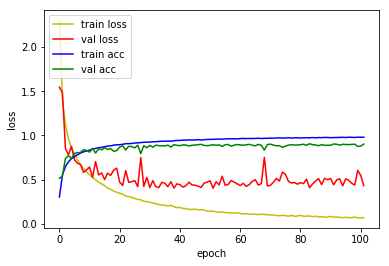

4815/4815 [==============================] - 4s 840us/sample - loss: 0.5010 - acc: 0.8779
Loss: 0.5010117996023699 Accuracy: 0.87788165

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3276 - acc: 0.2970
Epoch 00001: val_loss improved from inf to 1.53821, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_9_conv_checkpoint/001-1.5382.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.3276 - acc: 0.2971 - val_loss: 1.5382 - val_acc: 0.5132
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3552 - acc: 0.5711
Epoch 00002: val_loss improved from 1.53821 to 1.11776, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_9_conv_checkpoint/002-1.1178.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.3550 - acc: 0.5711 - val_loss: 1.1178 - val_acc: 0.6641
Epoch 3/500
36800/36805 [============================>.] -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9418
Epoch 00025: val_loss did not improve from 0.33479
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.1878 - acc: 0.9419 - val_loss: 0.4310 - val_acc: 0.8849
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1847 - acc: 0.9419
Epoch 00026: val_loss did not improve from 0.33479
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.1847 - acc: 0.9419 - val_loss: 0.4410 - val_acc: 0.8852
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9471
Epoch 00027: val_loss improved from 0.33479 to 0.31758, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_9_conv_checkpoint/027-0.3176.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.1720 - acc: 0.9470 - val_loss: 0.3176 - val_acc: 0.9234
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9775
Epoch 00054: val_loss did not improve from 0.31395
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0729 - acc: 0.9775 - val_loss: 0.3531 - val_acc: 0.9131
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9766
Epoch 00055: val_loss did not improve from 0.31395
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0710 - acc: 0.9766 - val_loss: 0.3328 - val_acc: 0.9217
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9785
Epoch 00056: val_loss did not improve from 0.31395
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0672 - acc: 0.9785 - val_loss: 0.3254 - val_acc: 0.9280
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0672 - acc: 0.9780
Epoch 00057: val_loss did not improve from 0.31395
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9865
Epoch 00084: val_loss did not improve from 0.31395
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0423 - acc: 0.9866 - val_loss: 0.3658 - val_acc: 0.9317
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9868
Epoch 00085: val_loss did not improve from 0.31395
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0411 - acc: 0.9868 - val_loss: 0.3550 - val_acc: 0.9264
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9866
Epoch 00086: val_loss did not improve from 0.31395
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0440 - acc: 0.9866 - val_loss: 0.5411 - val_acc: 0.8968
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9883
Epoch 00087: val_loss did not improve from 0.31395
36805/36805 [===========

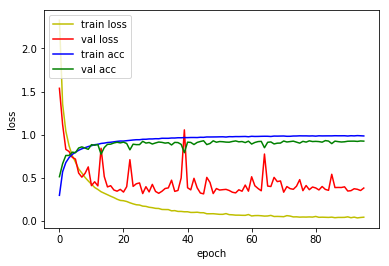

4815/4815 [==============================] - 4s 872us/sample - loss: 0.3824 - acc: 0.8989
Loss: 0.3823787293577739 Accuracy: 0.8988577

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3021 - acc: 0.2948
Epoch 00001: val_loss improved from inf to 1.66607, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_10_conv_checkpoint/001-1.6661.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.3021 - acc: 0.2948 - val_loss: 1.6661 - val_acc: 0.4314
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3438 - acc: 0.5712
Epoch 00002: val_loss improved from 1.66607 to 0.89485, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_10_conv_checkpoint/002-0.8949.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 1.3439 - acc: 0.5712 - val_loss: 0.8949 - val_acc: 0.7349
Epoch 3/500
36800/36805 [============================>.] 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9615
Epoch 00026: val_loss did not improve from 0.22453
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.1199 - acc: 0.9616 - val_loss: 0.2724 - val_acc: 0.9329
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1201 - acc: 0.9611
Epoch 00027: val_loss improved from 0.22453 to 0.22443, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_10_conv_checkpoint/027-0.2244.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.1201 - acc: 0.9611 - val_loss: 0.2244 - val_acc: 0.9392
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1150 - acc: 0.9633
Epoch 00028: val_loss did not improve from 0.22443
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.1150 - acc: 0.9633 - val_loss: 0.4832 - val_acc: 0.8691
Epoch 29/500
36800/36805 [============================>.] - ETA: 0

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9851
Epoch 00055: val_loss did not improve from 0.21883
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0454 - acc: 0.9851 - val_loss: 0.2953 - val_acc: 0.9343
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9848
Epoch 00056: val_loss did not improve from 0.21883
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0458 - acc: 0.9848 - val_loss: 0.3425 - val_acc: 0.9297
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9821
Epoch 00057: val_loss did not improve from 0.21883
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0573 - acc: 0.9821 - val_loss: 0.2434 - val_acc: 0.9436
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9906
Epoch 00058: val_loss did not improve from 0.21883
36805/36805 [===========


1D_CNN_custom_pool_2_ch_32_DO_BN_10_conv Model


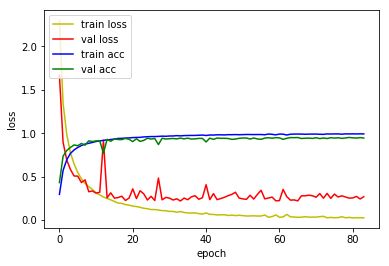

4815/4815 [==============================] - 5s 963us/sample - loss: 0.2690 - acc: 0.9263
Loss: 0.2690025930804503 Accuracy: 0.9262721

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3497 - acc: 0.2829
Epoch 00001: val_loss improved from inf to 1.51956, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_11_conv_checkpoint/001-1.5196.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.3496 - acc: 0.2830 - val_loss: 1.5196 - val_acc: 0.5164
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3251 - acc: 0.5730
Epoch 00002: val_loss improved from 1.51956 to 0.88141, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_11_conv_checkpoint/002-0.8814.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.3251 - acc: 0.5730 - val_loss: 0.8814 - val_acc: 0.7333
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9688
Epoch 00025: val_loss did not improve from 0.16333
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0931 - acc: 0.9688 - val_loss: 0.1818 - val_acc: 0.9499
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9728
Epoch 00026: val_loss did not improve from 0.16333
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0842 - acc: 0.9728 - val_loss: 0.2203 - val_acc: 0.9350
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0893 - acc: 0.9708
Epoch 00027: val_loss did not improve from 0.16333
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0893 - acc: 0.9708 - val_loss: 0.2237 - val_acc: 0.9408
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 0.9747
Epoch 00028: val_loss did not improve from 0.16333
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9902
Epoch 00054: val_loss did not improve from 0.14792
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0307 - acc: 0.9902 - val_loss: 0.2536 - val_acc: 0.9406
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9891
Epoch 00055: val_loss did not improve from 0.14792
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0364 - acc: 0.9890 - val_loss: 0.2277 - val_acc: 0.9490
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9862
Epoch 00056: val_loss did not improve from 0.14792
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0424 - acc: 0.9863 - val_loss: 0.1710 - val_acc: 0.9616
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9919
Epoch 00057: val_loss did not improve from 0.14792
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9941
Epoch 00084: val_loss did not improve from 0.14792
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0182 - acc: 0.9941 - val_loss: 0.2027 - val_acc: 0.9616
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9938
Epoch 00085: val_loss did not improve from 0.14792
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0197 - acc: 0.9938 - val_loss: 0.1802 - val_acc: 0.9604
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9928
Epoch 00086: val_loss did not improve from 0.14792
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.0221 - acc: 0.9928 - val_loss: 0.1935 - val_acc: 0.9553
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9961
Epoch 00087: val_loss did not improve from 0.14792
36805/36805 [===========

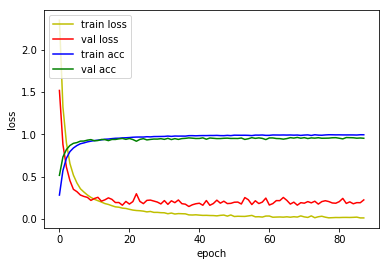

4815/4815 [==============================] - 5s 969us/sample - loss: 0.1830 - acc: 0.9502
Loss: 0.1829569949479319 Accuracy: 0.95015574

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2798 - acc: 0.3155
Epoch 00001: val_loss improved from inf to 1.42175, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_12_conv_checkpoint/001-1.4217.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 2.2796 - acc: 0.3155 - val_loss: 1.4217 - val_acc: 0.5679
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1402 - acc: 0.6417
Epoch 00002: val_loss improved from 1.42175 to 0.63712, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_12_conv_checkpoint/002-0.6371.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 1.1403 - acc: 0.6417 - val_loss: 0.6371 - val_acc: 0.8174
Epoch 3/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0706 - acc: 0.9783
Epoch 00025: val_loss did not improve from 0.13819
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0707 - acc: 0.9783 - val_loss: 0.1416 - val_acc: 0.9583
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9797
Epoch 00026: val_loss improved from 0.13819 to 0.13142, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_12_conv_checkpoint/026-0.1314.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0665 - acc: 0.9797 - val_loss: 0.1314 - val_acc: 0.9597
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9801
Epoch 00027: val_loss did not improve from 0.13142
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0630 - acc: 0.9801 - val_loss: 0.1623 - val_acc: 0.9513
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9942
Epoch 00054: val_loss did not improve from 0.13142
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0201 - acc: 0.9942 - val_loss: 0.2125 - val_acc: 0.9543
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9889
Epoch 00055: val_loss did not improve from 0.13142
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0347 - acc: 0.9889 - val_loss: 0.1686 - val_acc: 0.9620
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9950
Epoch 00056: val_loss did not improve from 0.13142
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.0180 - acc: 0.9950 - val_loss: 0.1478 - val_acc: 0.9660
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9882
Epoch 00057: val_loss did not improve from 0.13142
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9936
Epoch 00083: val_loss did not improve from 0.12456
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0218 - acc: 0.9935 - val_loss: 0.1787 - val_acc: 0.9618
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9954
Epoch 00084: val_loss did not improve from 0.12456
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0151 - acc: 0.9954 - val_loss: 0.1583 - val_acc: 0.9683
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9969
Epoch 00085: val_loss did not improve from 0.12456
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.0101 - acc: 0.9969 - val_loss: 0.1829 - val_acc: 0.9613
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9977
Epoch 00086: val_loss did not improve from 0.12456
36805/36805 [========================

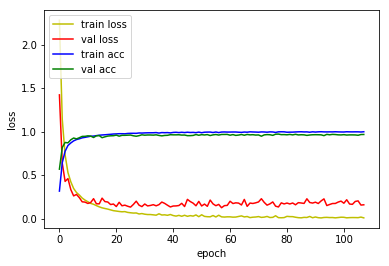

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1675 - acc: 0.9585
Loss: 0.1674612254484606 Accuracy: 0.95846313

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0037 - acc: 0.4027
Epoch 00001: val_loss improved from inf to 1.13555, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_13_conv_checkpoint/001-1.1355.hdf5
36805/36805 [==============================] - 118s 3ms/sample - loss: 2.0039 - acc: 0.4027 - val_loss: 1.1355 - val_acc: 0.6415
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8605 - acc: 0.7291
Epoch 00002: val_loss improved from 1.13555 to 0.53446, saving model to model/checkpoint/1D_CNN_custom_pool_2_ch_32_DO_BN_13_conv_checkpoint/002-0.5345.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.8604 - acc: 0.7291 - val_loss: 0.5345 - val_acc: 0.8321
Epoch 3/500
36800/36805 [============================>.] 

36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0633 - acc: 0.9799 - val_loss: 0.1363 - val_acc: 0.9616
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9880
Epoch 00027: val_loss did not improve from 0.13635
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0396 - acc: 0.9880 - val_loss: 0.1681 - val_acc: 0.9536
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9869
Epoch 00028: val_loss did not improve from 0.13635
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0422 - acc: 0.9869 - val_loss: 0.2224 - val_acc: 0.9411
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9845
Epoch 00029: val_loss did not improve from 0.13635
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0484 - acc: 0.9845 - val_loss: 0.2002 - val_acc: 0.9467
Epoch 30/500
36800/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9962
Epoch 00056: val_loss did not improve from 0.13635
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0122 - acc: 0.9962 - val_loss: 0.3586 - val_acc: 0.9180
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9958
Epoch 00057: val_loss did not improve from 0.13635
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0147 - acc: 0.9958 - val_loss: 0.1702 - val_acc: 0.9599
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9896
Epoch 00058: val_loss did not improve from 0.13635
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0329 - acc: 0.9896 - val_loss: 0.1939 - val_acc: 0.9581
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9964
Epoch 00059: val_loss did not improve from 0.13635
36805/36805 [========================

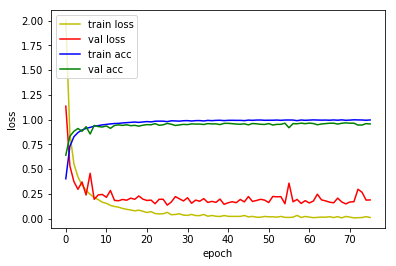

4815/4815 [==============================] - 5s 976us/sample - loss: 0.1817 - acc: 0.9553
Loss: 0.18170474947353793 Accuracy: 0.9553479



In [10]:
for i in range(3, 14):
    base = '1D_CNN_custom_pool_2_ch_32_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_pool_2_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_pool_2_ch_32_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_88 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_88 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_89 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_77 (MaxPooling 

4815/4815 [==============================] - 5s 943us/sample - loss: 1.3318 - acc: 0.6422
Loss: 1.3317909630659586 Accuracy: 0.64215994

1D_CNN_custom_pool_2_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_100 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_101 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_101 (Activatio

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6977 - acc: 0.8123
Loss: 0.6976641787918186 Accuracy: 0.81225336

1D_CNN_custom_pool_2_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_113 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_113 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_113 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_114 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_114 (Activation)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3824 - acc: 0.8989
Loss: 0.3823787293577739 Accuracy: 0.8988577

1D_CNN_custom_pool_2_ch_32_DO_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_130 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_130 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_131 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_131 (Activation)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1830 - acc: 0.9502
Loss: 0.1829569949479319 Accuracy: 0.95015574

1D_CNN_custom_pool_2_ch_32_DO_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_151 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_151 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_152 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_152 (Activation

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1817 - acc: 0.9553
Loss: 0.18170474947353793 Accuracy: 0.9553479


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_pool_2_ch_32_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_88 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_88 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_89 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_77 (MaxPooling 

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.7536 - acc: 0.6808
Loss: 1.7535890278415145 Accuracy: 0.6807892

1D_CNN_custom_pool_2_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_100 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_101 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_101 (Activation) 

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.7833 - acc: 0.8235
Loss: 0.7833376250410624 Accuracy: 0.8234683

1D_CNN_custom_pool_2_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_113 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_113 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_113 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_114 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_114 (Activation) 

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.4565 - acc: 0.9057
Loss: 0.4565377076219299 Accuracy: 0.9057113

1D_CNN_custom_pool_2_ch_32_DO_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_130 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_130 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_131 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_131 (Activation)

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2244 - acc: 0.9495
Loss: 0.22439268051684366 Accuracy: 0.9495327

1D_CNN_custom_pool_2_ch_32_DO_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_151 (Conv1D)          (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_151 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_152 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_152 (Activation

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2602 - acc: 0.9464
Loss: 0.2601728303405347 Accuracy: 0.94641745
